In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
from scipy.stats import poisson, binom, nbinom, lognorm, pareto, gamma, scoreatpercentile
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from kmodes.kmodes import KModes
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, silhouette_score, davies_bouldin_score

In [102]:
# Load the claims data file into a DataFrame 
file_path = "claim_data_group4_2024.csv"
claims_data_df = pd.read_csv(file_path)
claims_data_df

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
0,2271893,0,0.83,E,5,17,53,64,B2,Diesel,3317,R93,0.0
1,1111864,0,0.24,E,5,2,27,64,B3,Diesel,2740,R22,0.0
2,72908,0,0.50,E,7,11,67,50,B3,Regular,4762,R93,0.0
3,2283027,0,0.08,B,5,8,28,60,B1,Diesel,64,R91,0.0
4,1123838,0,0.03,A,11,1,38,50,B2,Regular,16,R24,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,70445,0,1.00,C,5,11,37,56,B2,Diesel,317,R82,0.0
99996,4163362,0,0.22,E,6,13,58,50,B1,Diesel,4762,R93,0.0
99997,2081912,0,1.00,E,5,1,49,50,B2,Diesel,4998,R11,0.0
99998,2012998,0,0.71,D,9,9,36,54,B1,Regular,1541,R91,0.0


In [103]:
# Claim frequency will be used instead for number of claims as the period of exposure, meaning, the time a claim can occur, is also considered.
# Claim severity is the average claim amount per claim and will be used instead of the claim amount. 
claims_data_df['Frequency'] = claims_data_df['ClaimNb'] / claims_data_df['Exposure'] #Number of claims per year
claims_data_df['Severity'] = claims_data_df['ClaimAmount'] / claims_data_df['ClaimNb'] #Amount per claim

# Drop the original columns and place the new columns at the same position as the original columns 
claims_data = claims_data_df.drop(columns=['ClaimNb'])
#claims_data = claims_data[['Frequency','Exposure', 'Area', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'VehBrand', 'VehGas', 'Density', 'Region', 'Severity']]

# Fill missing values in the 'Severity' column with 0 (meaning no claim occurred)
claims_data['Severity'] = claims_data['Severity'].fillna(0)

# Descriptive Statistics

In [61]:
def plot_variable(data, group_var, ax_freq, ax_sev):
    """
    Function to plot frequency and severity of claims by policyholder characteristics.
    
    :param data: DataFrame to plot.
    :param group_var: The variable to group by.
    :param ax_freq: The axes object for frequency plots.
    :param ax_sev: The axes object for severity plots.
    """
    # Calculate frequency and severity
    freq = data.groupby(group_var)['Frequency'].sum()
    sev = data[data['Frequency'] > 0].groupby(group_var)['ClaimAmount'].mean()
    
    dollar_formatter = FuncFormatter(lambda x, pos: f'${int(x)}')

    # Plot Frequency
    sns.barplot(x=freq.index, y=freq.values, ax=ax_freq)
    ax_freq.set_title(f'Claim Frequency by {group_var}')
    ax_freq.set_xlabel(group_var)
    ax_freq.set_ylabel('Total Claims')
    ax_freq.tick_params(axis='x')
    if group_var in ['BonusMalus','DrivAge', 'VehAge']:
        ax_freq.xaxis.set_major_locator(MaxNLocator(10))

    # Plot Severity
    sns.barplot(x=sev.index, y=sev.values, ax=ax_sev)
    ax_sev.set_title(f'Claim Severity by {group_var}')
    ax_sev.set_xlabel(group_var)
    ax_sev.set_ylabel('Average Claim Amount')
    ax_sev.tick_params(axis='x')
    ax_sev.yaxis.set_major_formatter(dollar_formatter)
    if group_var in ['BonusMalus', 'DrivAge']:
        ax_sev.xaxis.set_major_locator(MaxNLocator(10))

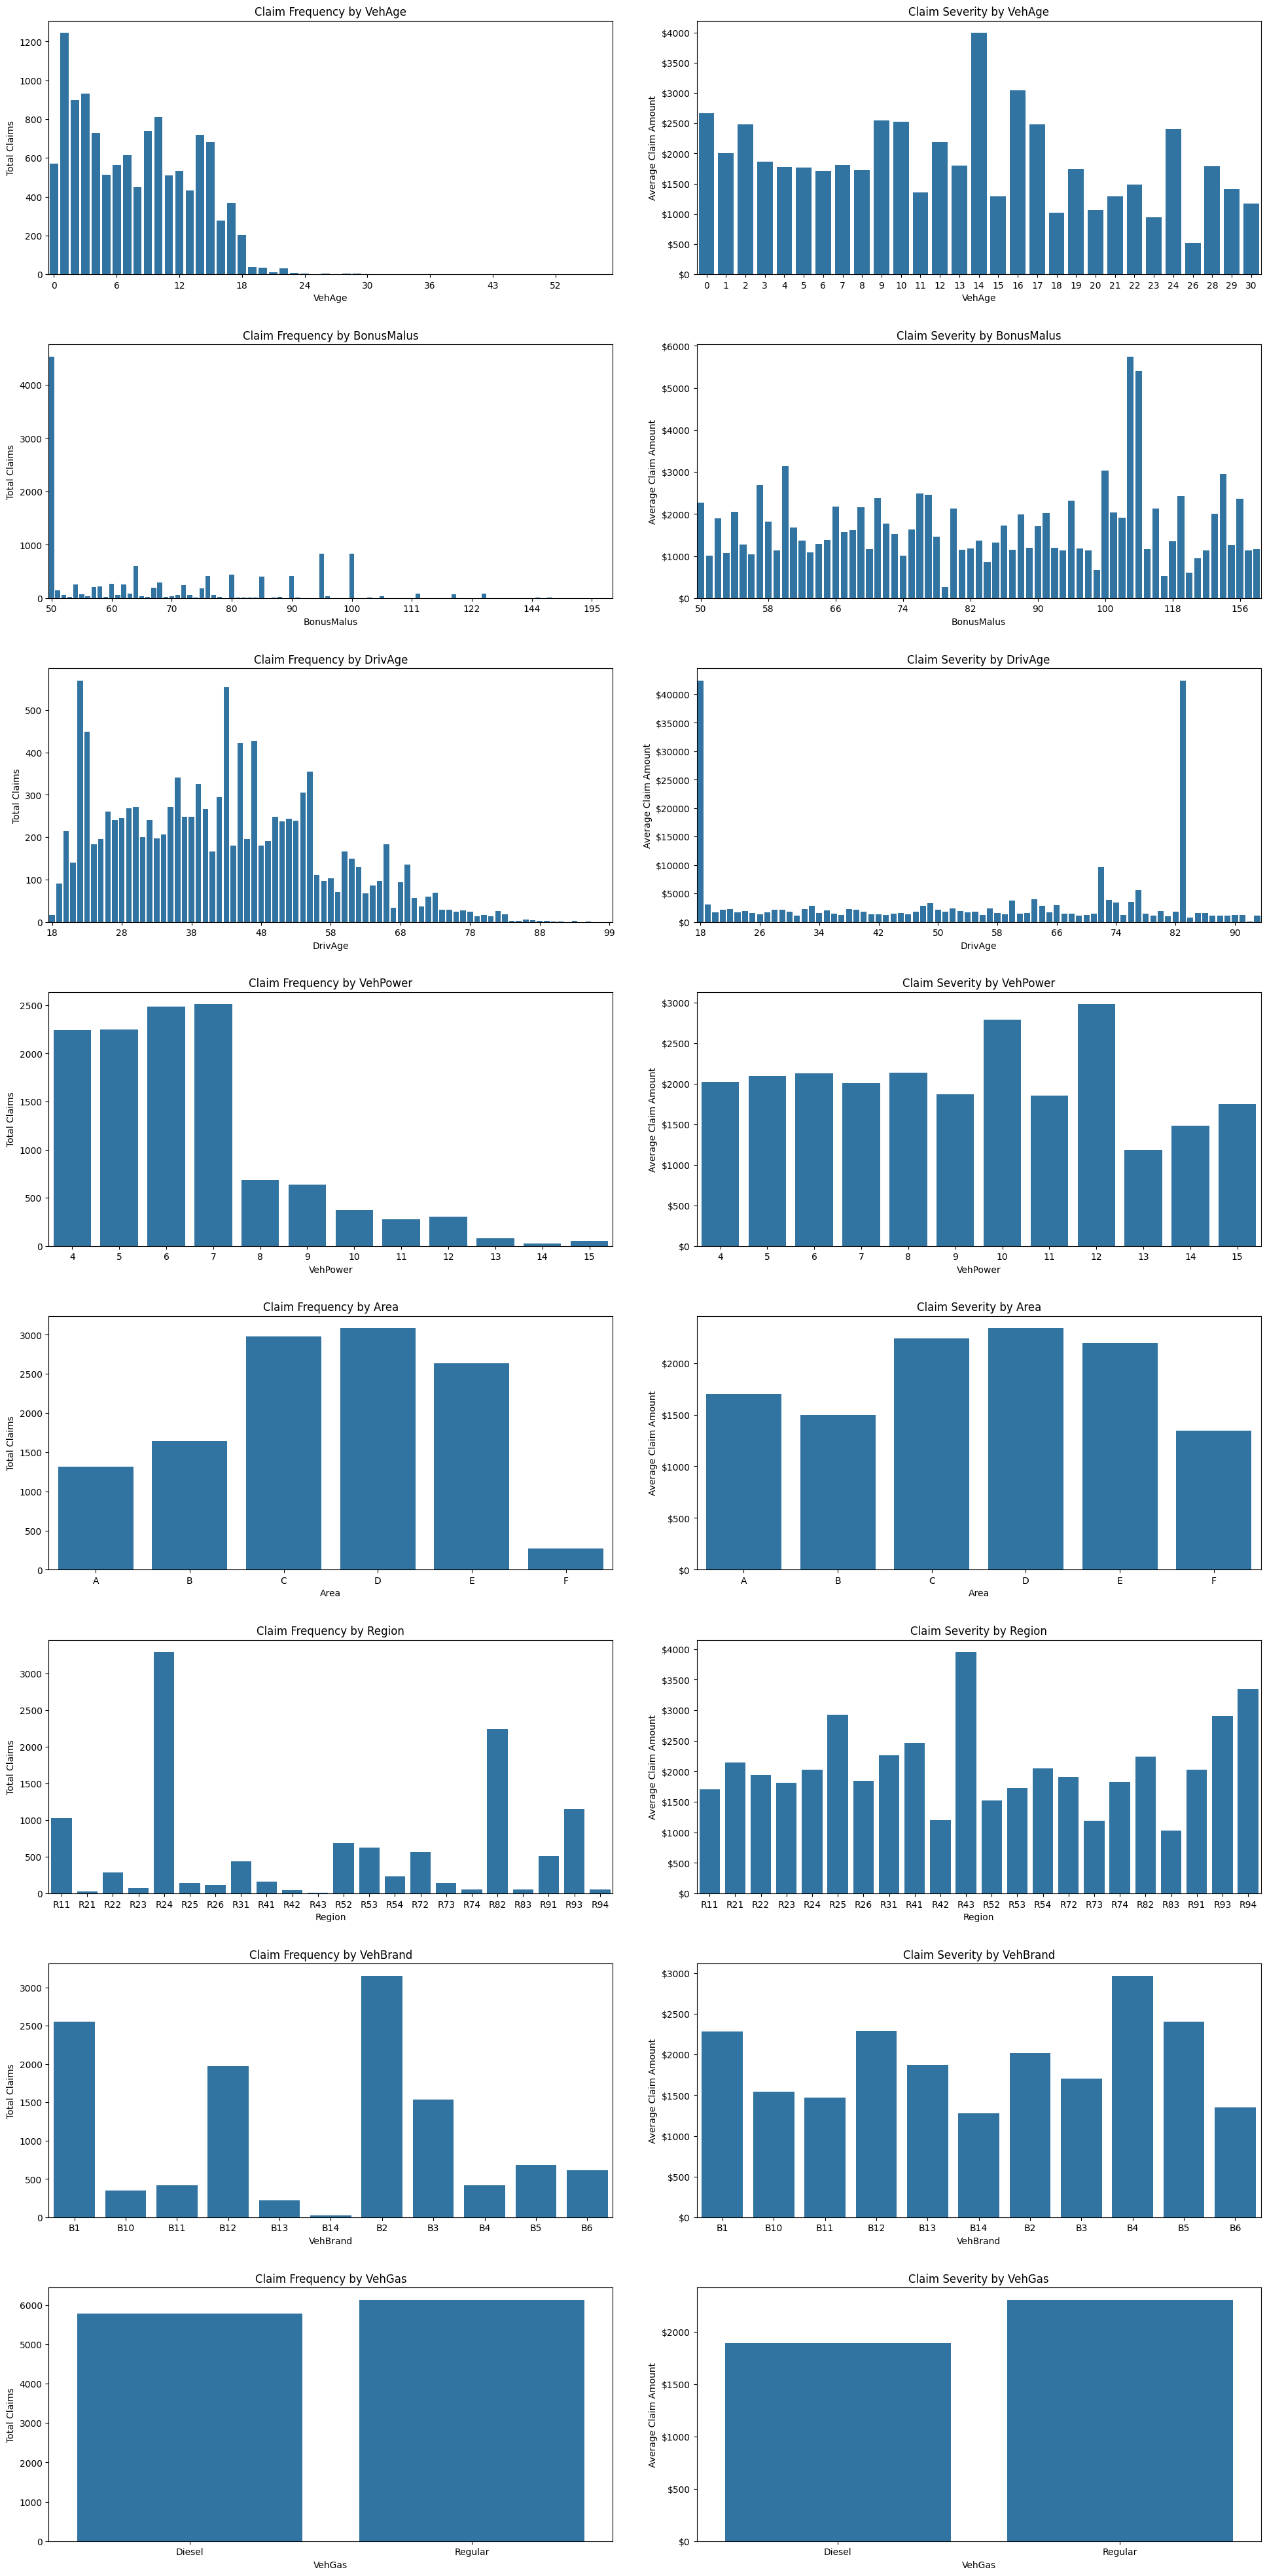

In [62]:
# Variables to plot frequency and severity of claims by policyholder characteristics
variables = ['VehAge', 'BonusMalus', 'DrivAge', 'VehPower', 'Area','Region', 'VehBrand', 'VehGas']

fig, axes = plt.subplots(nrows=len(variables), ncols=2, figsize=(20, 5 * len(variables))) 

# Loop through each variable and apply the plotting function on subplots
for idx, var in enumerate(variables):
    plot_variable(claims_data, var, axes[idx, 0], axes[idx, 1])

plt.tight_layout(pad=3.0) 
plt.show()

In [63]:
# Check for correlation between risk caracteristics
claims_data[['VehPower', 'DrivAge', 'BonusMalus', 'VehAge', 'Density']].corr()

,VehPower,DrivAge,BonusMalus,VehAge,Density
VehPower,1.000000,0.028375,-0.077144,-0.006254,0.044586
DrivAge,0.028375,1.000000,-0.480037,-0.057351,-0.005337
BonusMalus,-0.077144,-0.480037,1.000000,0.084034,0.080366
VehAge,-0.006254,-0.057351,0.084034,1.000000,-0.091280
Density,0.044586,-0.005337,0.080366,-0.091280,1.000000


In [64]:
# Get descriptive statistics from the claims data set 
descriptive_stats = claims_data.describe()
descriptive_stats

,IDpol,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimAmount,Frequency,Severity
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000
mean,2.617735e+06,0.528057,6.460230,6.992550,45.483040,59.822980,1800.69569,76.599887,0.119194,70.764054
std,1.643394e+06,0.364232,2.055641,5.637297,14.154698,15.652541,3955.08311,1531.841302,2.141210,1448.674413
min,1.500000e+01,0.002732,4.000000,0.000000,18.000000,50.000000,2.00000,0.000000,0.000000,0.000000
25%,1.156127e+06,0.170000,5.000000,2.000000,34.000000,50.000000,94.00000,0.000000,0.000000,0.000000
50%,2.271008e+06,0.490000,6.000000,6.000000,44.000000,50.000000,399.00000,0.000000,0.000000,0.000000
75%,4.044791e+06,0.990000,7.000000,11.000000,55.000000,65.000000,1658.00000,0.000000,0.000000,0.000000
max,6.114324e+06,1.000000,15.000000,100.000000,99.000000,230.000000,27000.00000,200000.000000,365.000004,200000.000000


In [65]:
total_claims_frequency = pd.DataFrame(claims_data['Frequency'].value_counts())
total_claims_frequency

,count
Frequency,
0.000000,96335
1.000000,1247
2.000000,146
2.040816,59
4.166667,53
...,...
22.222222,1
2.597403,1
121.666668,1


In [66]:
total_claims_severity = pd.DataFrame(claims_data['Severity'].value_counts())
total_claims_severity

,count
Severity,
0.00,96335
1204.00,662
1128.12,409
1172.00,290
1128.00,96
...,...
1307.64,1
1858.81,1
741.77,1


In [67]:
# Total claims by driver's age 
total_claims_by_age_frequency = claims_data.groupby('DrivAge')['Frequency'].sum()
total_claims_by_age_severity = claims_data.groupby('DrivAge')['ClaimAmount'].sum()
total_claims_by_age_frequency = pd.DataFrame(total_claims_by_age_frequency)
total_claims_by_age_severity = pd.DataFrame(total_claims_by_age_severity)
pd.concat([total_claims_by_age_frequency, total_claims_by_age_severity], axis=1)

,Frequency,ClaimAmount
DrivAge,,
18,16.322587,211932.67
19,91.403724,82079.72
20,213.609450,91491.80
21,140.569510,87797.24
22,569.546878,113956.44
...,...,...
94,0.000000,0.00
95,1.234568,1172.00
96,0.000000,0.00


In [68]:
# Total claims by vehicle's age 
total_claims_by_vech_age_frequency = claims_data.groupby('VehAge')['Frequency'].sum()
total_claims_by_vech_age_severity = claims_data.groupby('VehAge')['ClaimAmount'].sum()
total_claims_by_vech_age_frequency = pd.DataFrame(total_claims_by_vech_age_frequency)
total_claims_by_vech_age_severity = pd.DataFrame(total_claims_by_vech_age_severity)
pd.concat([total_claims_by_vech_age_frequency, total_claims_by_vech_age_severity], axis=1)

,Frequency,ClaimAmount
VehAge,,
0,570.358022,410632.54
1,1244.758156,605801.74
2,896.493005,776033.31
3,930.549972,508193.74
4,729.686639,441865.37
5,511.978097,384044.79
6,562.314874,351768.86
7,615.062916,395305.52
8,450.012112,378182.60


In [69]:
# Total claims by Bonus/Malus 
total_claims_by_bonus_malus_frequency = claims_data.groupby('BonusMalus')['Frequency'].sum()
total_claims_by_bonus_malus_severity = claims_data.groupby('BonusMalus')['ClaimAmount'].sum()
total_claims_by_vech_age_frequency = pd.DataFrame(total_claims_by_bonus_malus_frequency)
total_claims_by_bonus_malus_severity = pd.DataFrame(total_claims_by_bonus_malus_severity)
pd.concat([total_claims_by_bonus_malus_frequency, total_claims_by_bonus_malus_severity], axis=1)

,Frequency,ClaimAmount
BonusMalus,,
50,4527.854394,3650556.48
51,144.747215,57993.15
52,66.867186,51447.90
53,27.815301,19397.49
54,260.253699,125119.17
...,...,...
190,0.000000,0.00
195,0.000000,0.00
196,0.000000,0.00


In [70]:
# Total claims by vechicle's power 
total_claims_by_vech_power_frequency = claims_data.groupby('VehPower')['Frequency'].sum()
total_claims_by_vech_power_severity = claims_data.groupby('VehPower')['ClaimAmount'].sum()
total_claims_by_vech_power_frequency = pd.DataFrame(total_claims_by_vech_power_frequency)
total_claims_by_vech_power_severity = pd.DataFrame(total_claims_by_vech_power_severity)
pd.concat([total_claims_by_vech_power_frequency, total_claims_by_vech_power_severity], axis=1)

,Frequency,ClaimAmount
VehPower,,
4,2241.808393,994335.45
5,2248.298384,1523507.54
6,2487.080157,1862209.18
7,2509.899334,1591878.39
8,686.681816,518985.02
9,637.763083,340514.78
10,374.189024,407308.33
11,274.163323,191014.30
12,305.273969,158011.39


# Cluster

*Catégorisation des variables*

In [104]:
# Function to perform quantile binning 
def quantile_binning_and_apply(claims_data, features, n_bins, specific_bins=None):
    bin_labels_dict = {}
    for feature in features:
        # Utiliser un nombre de bins spécifique si fourni, sinon utiliser n_bins
        bins = specific_bins.get(feature, n_bins) if specific_bins else n_bins
        bin_edges = pd.qcut(claims_data[feature], q=bins, retbins=True, duplicates='drop')[1]
        bin_edges[-1] += 1e-5
        labels = [f'{bin_edges[i]:.1f}-{bin_edges[i+1]:.1f}' for i in range(len(bin_edges)-1)]
        claims_data[f'Binned {feature}'] = pd.cut(claims_data[feature], bins=bin_edges, labels=labels, include_lowest=True, duplicates='drop')
        bin_labels_dict[f'Binned {feature}'] = labels
        print(f'Labels for {feature}: {labels}')
    return bin_labels_dict

# Treatment of BonusMalus
claims_data['Binned BonusMalus'] = claims_data['BonusMalus'].apply(lambda x: 'Bonus' if x <= 100 else 'Malus')

In [105]:
# List of features to bin 
features = ['DrivAge', 'VehAge','VehPower']
n_bins = 10

# Définir un nombre de bins spécifique pour DrivAge
specific_bins = {'DrivAge': 20}  # Par exemple, 30 bins pour DrivAge pour plus de granularité

# Call the function
bin_labels_dict = quantile_binning_and_apply(claims_data, features, n_bins, specific_bins)

Labels for DrivAge: ['18.0-25.0', '25.0-28.0', '28.0-30.0', '30.0-32.0', '32.0-34.0', '34.0-36.0', '36.0-38.0', '38.0-40.0', '40.0-42.0', '42.0-44.0', '44.0-46.0', '46.0-48.0', '48.0-51.0', '51.0-53.0', '53.0-55.0', '55.0-57.0', '57.0-61.0', '61.0-65.0', '65.0-72.0', '72.0-99.0']
Labels for VehAge: ['0.0-1.0', '1.0-2.0', '2.0-3.0', '3.0-4.0', '4.0-6.0', '6.0-8.0', '8.0-10.0', '10.0-12.0', '12.0-15.0', '15.0-100.0']
Labels for VehPower: ['4.0-5.0', '5.0-6.0', '6.0-7.0', '7.0-8.0', '8.0-9.0', '9.0-15.0']


*Determining the optimal amount of clusters*

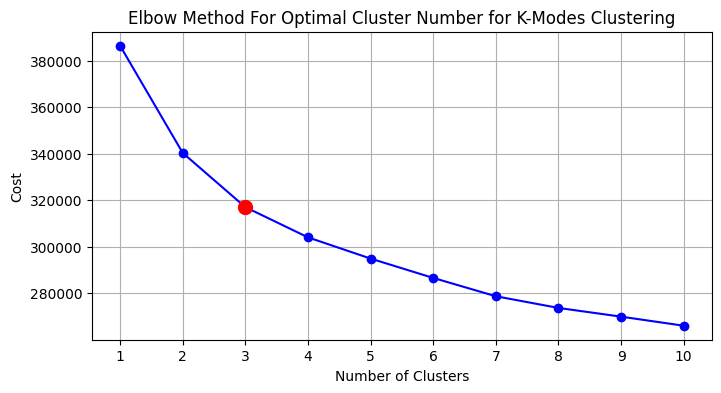

In [73]:
# Additional categorical columns
additional_categorical_columns = ['Area', 'VehBrand', 'Binned BonusMalus']

# Prepare data for one-hot encoding
categorical_columns = [f'Binned {feature}' for feature in features] + additional_categorical_columns
for col in categorical_columns:
    claims_data[col] = claims_data[col].astype('category')

# Use only categorical columns for clustering 
df_categorical = claims_data[categorical_columns]

# Convert the DataFrame to a numpy array before applying K-Modes 
data_matrix = df_categorical.to_numpy()

# Apply the elbow method to find the optimal number of clusters for K-Modes clustering method
cost = []
K = range(1, 11)  # Range of clusters to try
for num_clusters in K:
    kmodes = KModes(n_clusters=num_clusters, random_state=42)
    clusters = kmodes.fit_predict(data_matrix)
    cost.append(kmodes.cost_)

# Plot the elbow graph
plt.figure(figsize=(8, 4))
plt.plot(K, cost, marker='o', color='b')
plt.xlabel('Number of Clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal Cluster Number for K-Modes Clustering')
plt.xticks(K)
plt.grid(True)

# Highlight the optimal number of clusters (3) in red 
optimal_k = 3
plt.plot(optimal_k, cost[optimal_k - 1], marker='o', markersize=10, color='r')
plt.show()

*Creating the clusters using K-Modes Clustering Method*

In [106]:
# Additional categorical columns
additional_categorical_columns = ['Area', 'VehBrand', 'Binned BonusMalus'] # See if we add more columns to improve the clustering results 

# Prepare data for categorical columns 
# Combine binned features and additional categorical columns
categorical_columns = [f'Binned {feature}' for feature in features] + additional_categorical_columns

# Convert categorical columns to category type
for col in categorical_columns:
    claims_data[col] = claims_data[col].astype('category')

# Use only categorical columns for clustering
df_categorical = claims_data[categorical_columns]

# Convert the DataFrame to a numpy array
data_matrix = df_categorical.to_numpy()

# Apply K-Modes clustering with the optimal number of clusters 
kmodes = KModes(n_clusters=3, random_state=42)

# Fit the model to the data 
clusters = kmodes.fit_predict(data_matrix)

# Store the result in 'Risk Cluster' column 
claims_data['Risk Cluster K-Mode'] = clusters

*Validate the clusters defined by the K-Modes algorithm using CatBoostClassifier*

In [107]:
# Extract labels from the 'Risk Cluster' column of K-Modes clustering
labels = claims_data['Risk Cluster K-Mode']

# Identify categorical feature indices
cat_features_indices = [df_categorical.columns.get_loc(col) for col in categorical_columns]

# Split the data into training and testing sets (20% test data) and use the rest as training data (20% was the best split ratio based on GridSearchCV results optimization run)
X_train, X_test, y_train, y_test = train_test_split(df_categorical, labels, test_size=0.2, random_state=42)

# Train a CatBoost classifier with adjusted parameters
model = CatBoostClassifier(
    iterations=500,          # Number of iterations are based on GridSearchCV results optimization run to find the best parameters 
    learning_rate=0.1,      # Number of iterations are based on GridSearchCV results optimization run to find the best parameters
    depth=10,                 # Depth of the tree are based on GridSearchCV results optimization run to find the best parameters
    random_seed=42,          # Random seed for reproducibility
    cat_features=cat_features_indices # Categorical feature indices for CatBoost model to use 
    )
model.fit(X_train, y_train)

# Predict on the entire dataset to see the predicted risk clusters (Validation) 
claims_data['Predicted Risk Cluster'] = model.predict(df_categorical)

0:	learn: 0.9590885	total: 107ms	remaining: 53.2s
1:	learn: 0.8522171	total: 171ms	remaining: 42.5s
2:	learn: 0.7631748	total: 238ms	remaining: 39.4s
3:	learn: 0.6881025	total: 302ms	remaining: 37.5s
4:	learn: 0.6271395	total: 382ms	remaining: 37.8s
5:	learn: 0.5744777	total: 447ms	remaining: 36.8s
6:	learn: 0.5302366	total: 505ms	remaining: 35.5s
7:	learn: 0.4912163	total: 559ms	remaining: 34.4s
8:	learn: 0.4535651	total: 608ms	remaining: 33.2s
9:	learn: 0.4194899	total: 655ms	remaining: 32.1s
10:	learn: 0.3890516	total: 702ms	remaining: 31.2s
11:	learn: 0.3618022	total: 799ms	remaining: 32.5s
12:	learn: 0.3339199	total: 847ms	remaining: 31.7s
13:	learn: 0.3095599	total: 892ms	remaining: 31s
14:	learn: 0.2900302	total: 939ms	remaining: 30.3s
15:	learn: 0.2721421	total: 988ms	remaining: 29.9s
16:	learn: 0.2551998	total: 1.04s	remaining: 29.4s
17:	learn: 0.2394547	total: 1.09s	remaining: 29.3s
18:	learn: 0.2250239	total: 1.16s	remaining: 29.3s
19:	learn: 0.2109746	total: 1.21s	remaining

TypeError: The x variable is categorical, but one of ['numeric', 'datetime'] is required

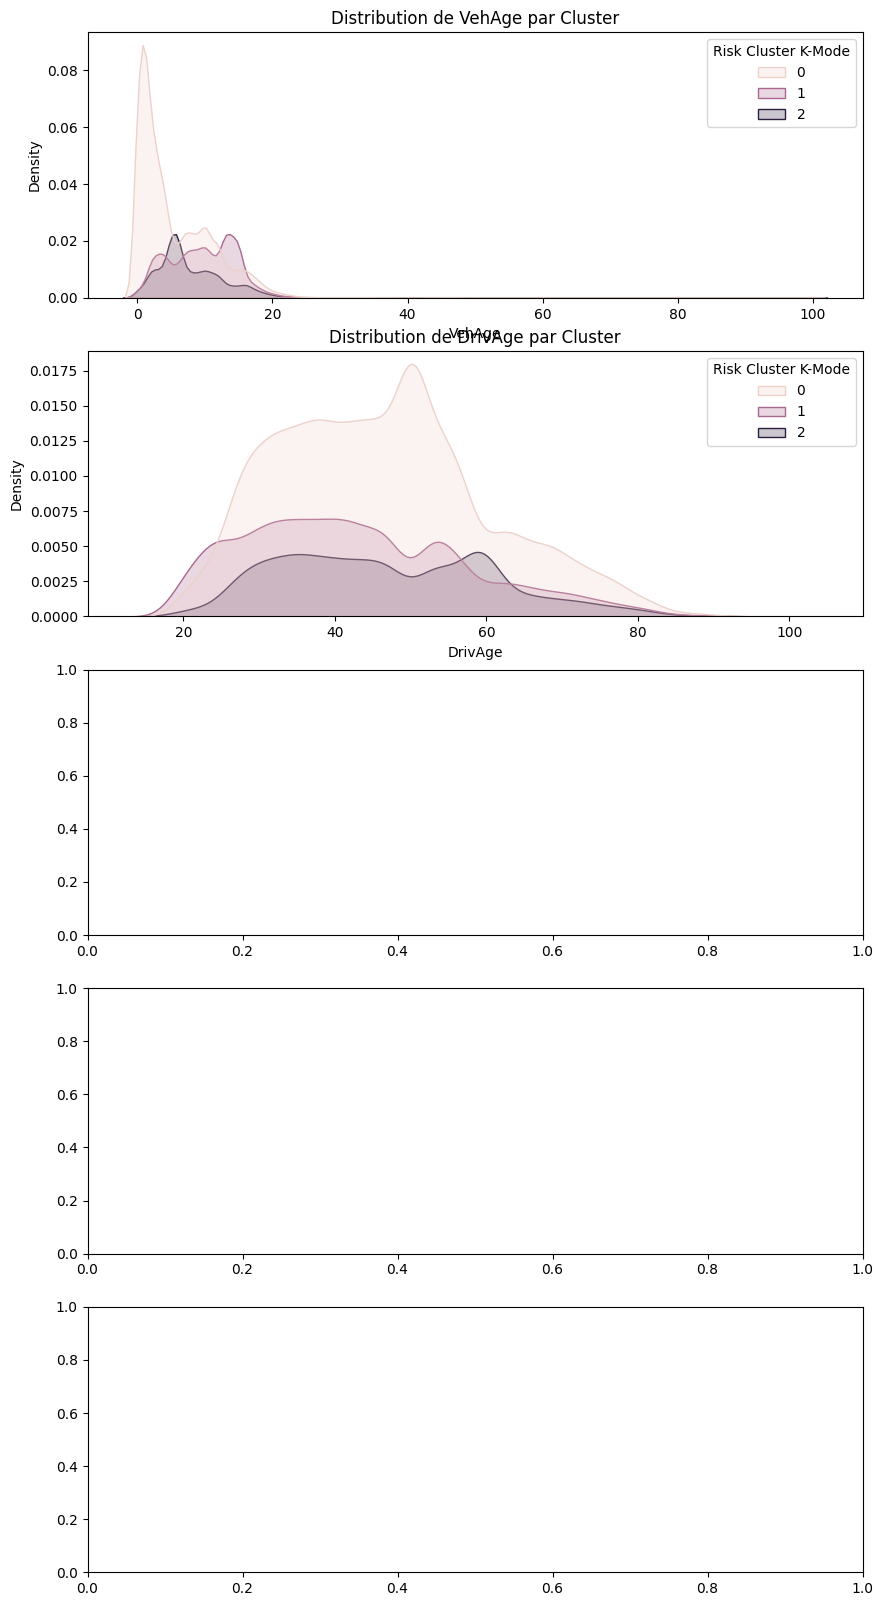

In [112]:
variables = ['VehAge', 'DrivAge', 'VehBrand', 'VehPower', 'Area']
fig, axes = plt.subplots(len(variables), 1, figsize=(10, 20))
for i, var in enumerate(variables):
    sns.kdeplot(data=claims_data, x=var, hue='Predicted Risk Cluster', fill=True, ax=axes[i])
    axes[i].set_title(f'Distribution de {var} par Cluster')

plt.tight_layout()
plt.show()

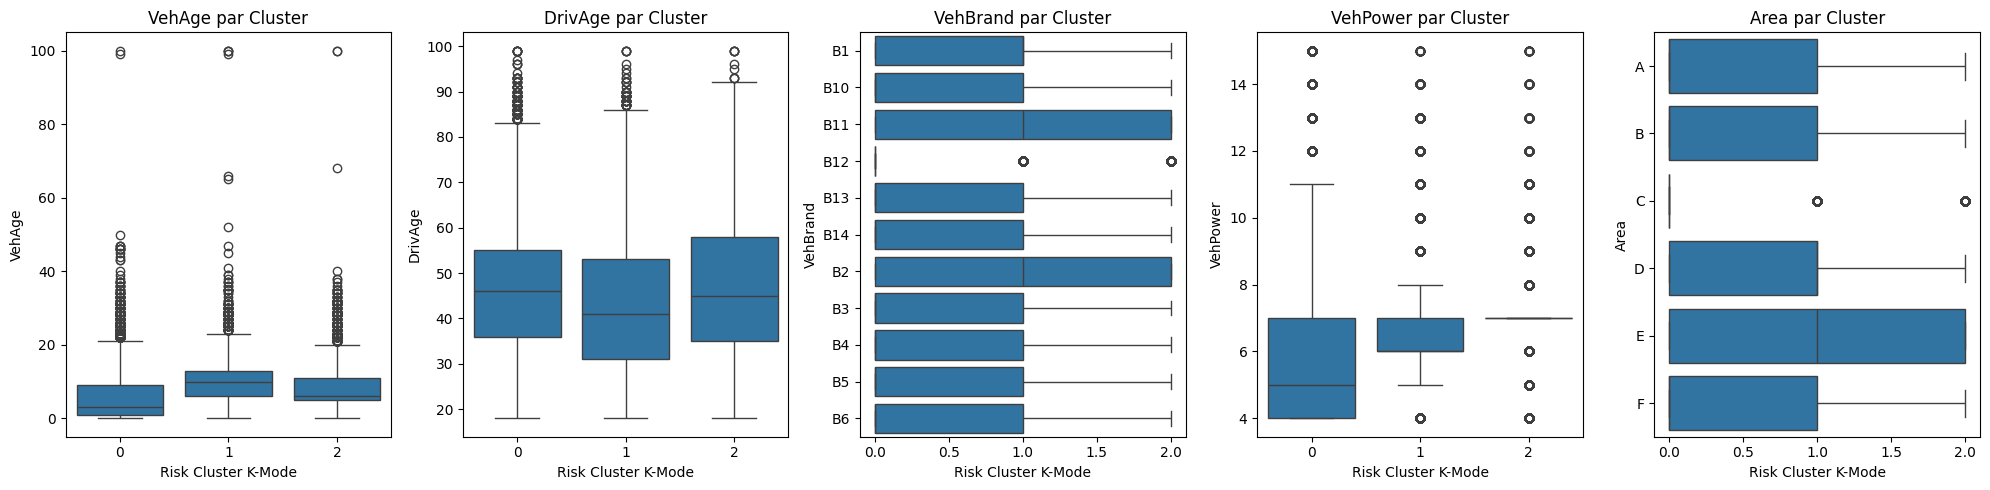

In [114]:
variables = ['VehAge', 'DrivAge', 'VehBrand', 'VehPower', 'Area']
fig, axes = plt.subplots(1, len(variables), figsize=(20, 5))
for i, var in enumerate(variables):
    sns.boxplot(data=claims_data, x='Predicted Risk Cluster', y=var, ax=axes[i])
    axes[i].set_title(f'{var} par Cluster')

plt.tight_layout()
plt.show()

*Cross Validation Test for Catboost predictive model*

In [80]:
# Perform cross-validation
cv_scores = cross_val_score(model, df_categorical, labels, cv=5, scoring='accuracy')

# Print cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

0:	learn: 0.9668572	total: 54.1ms	remaining: 27s
1:	learn: 0.8694815	total: 98.9ms	remaining: 24.6s
2:	learn: 0.7872921	total: 144ms	remaining: 23.9s
3:	learn: 0.7095477	total: 190ms	remaining: 23.6s
4:	learn: 0.6436884	total: 236ms	remaining: 23.4s
5:	learn: 0.5900515	total: 281ms	remaining: 23.2s
6:	learn: 0.5447845	total: 324ms	remaining: 22.8s
7:	learn: 0.5039698	total: 367ms	remaining: 22.6s
8:	learn: 0.4679559	total: 410ms	remaining: 22.4s
9:	learn: 0.4360790	total: 453ms	remaining: 22.2s
10:	learn: 0.4032829	total: 497ms	remaining: 22.1s
11:	learn: 0.3731734	total: 543ms	remaining: 22.1s
12:	learn: 0.3497200	total: 588ms	remaining: 22s
13:	learn: 0.3238842	total: 632ms	remaining: 21.9s
14:	learn: 0.3017919	total: 690ms	remaining: 22.3s
15:	learn: 0.2823201	total: 743ms	remaining: 22.5s
16:	learn: 0.2642639	total: 791ms	remaining: 22.5s
17:	learn: 0.2464323	total: 840ms	remaining: 22.5s
18:	learn: 0.2315482	total: 885ms	remaining: 22.4s
19:	learn: 0.2170596	total: 929ms	remaining

# Interpret Clusters and Validate Clusters as Risk Groups

In [93]:
# Enconding categorical data to evaluate the clusters
df_categorical_encoded = OneHotEncoder().fit_transform(df_categorical)
silhouette = silhouette_score(df_categorical_encoded, claims_data['Predicted Risk Cluster'])
davies_bouldin = davies_bouldin_score(df_categorical_encoded.toarray(), claims_data['Predicted Risk Cluster'])

print(f"Silhouette Score: {silhouette}")
print(f"Davies Bouldin Score: {davies_bouldin}")

Silhouette Score: 0.04166128773615188
Davies Bouldin Score: 4.020328720316979


*Extraire les caractéristiques dominantes de chaque cluster : Utiliser les centroids des clusters pour comprendre les caractéristiques principales de chaque groupe.*

In [115]:
# Count the number of data points in each cluster predicted by the CatBoost model
predicted_cluster_counts = claims_data['Risk Cluster K-Mode'].value_counts()
print("Number of data points in each predicted cluster:")
print(predicted_cluster_counts)

# Function to get the most frequent values (mode) for each feature in each cluster
def get_cluster_modes(df, cluster_col, feature_cols):
    cluster_modes = df.groupby(cluster_col)[feature_cols].agg(lambda x: x.mode().iloc[0])
    return cluster_modes

# Columns to analyze
feature_cols = ['Binned DrivAge', 'Binned VehAge', 'Binned VehPower', 'Area', 'VehBrand', 'Binned BonusMalus']

# Get the most frequent values for each cluster
cluster_modes = get_cluster_modes(claims_data,'Risk Cluster K-Mode', feature_cols)

# Display common characteristics for each cluster
cluster_modes

Number of data points in each predicted cluster:
Risk Cluster K-Mode
0    56680
1    26313
2    17007
Name: count, dtype: int64


,Binned DrivAge,Binned VehAge,Binned VehPower,Area,VehBrand,Binned BonusMalus
Risk Cluster K-Mode,,,,,,
0,48.0-51.0,0.0-1.0,4.0-5.0,C,B12,Bonus
1,18.0-25.0,12.0-15.0,5.0-6.0,D,B1,Bonus
2,57.0-61.0,4.0-6.0,6.0-7.0,E,B2,Bonus


/var/folders/xs/v3nn216s5j37yby_qfjm69940000gn/T/ipykernel_19713/1522491041.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(data=cluster_frequency, x='Risk Cluster K-Mode', y='Frequency', palette= 'viridis')


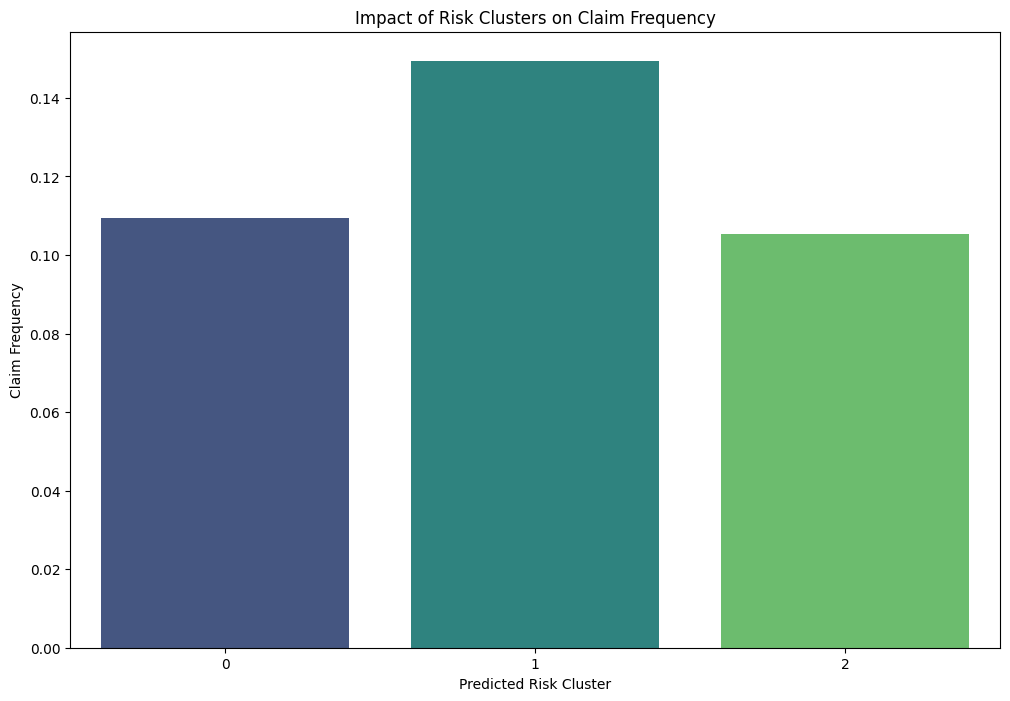

In [117]:
# Calculate the mean claim frequency for each predicted risk cluster
cluster_frequency = claims_data.groupby('Risk Cluster K-Mode')['Frequency'].mean().reset_index()

# Create a bar plot to visualize the impact of each cluster on claim frequency
plt.figure(figsize=(12, 8))
bar_plot = sns.barplot(data=cluster_frequency, x='Risk Cluster K-Mode', y='Frequency', palette= 'viridis')

plt.title('Impact of Risk Clusters on Claim Frequency')
plt.xlabel('Predicted Risk Cluster')
plt.ylabel('Claim Frequency')
plt.show()

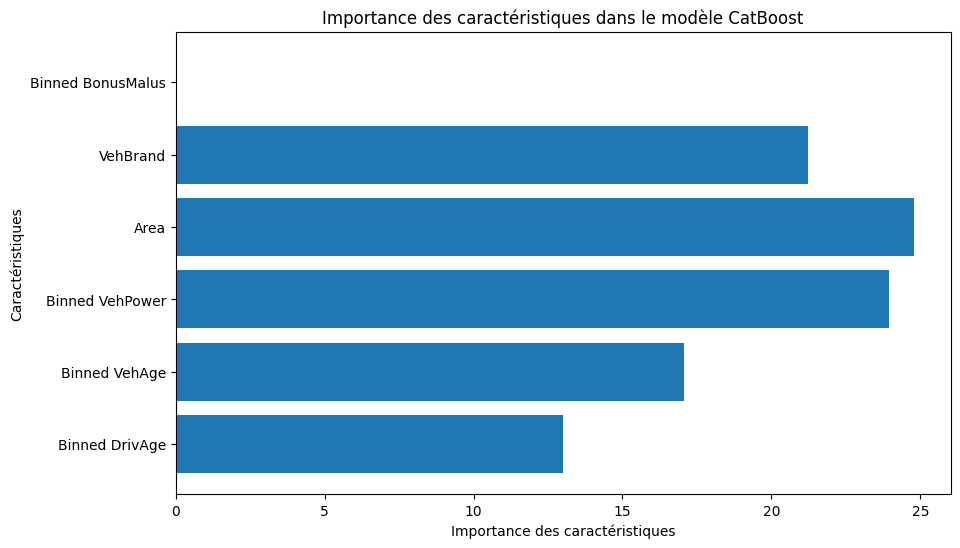

In [118]:
# CatBoost provides built-in methods to extract feature importance, which can offer insights into what features are driving the distinctions between clusters.
# Obtain which features are most important for predicting the cluster labels.
feature_importances = model.get_feature_importance()
feature_names = df_categorical.columns

# Create a bar plot to visualize the importance of each feature in the CatBoost model
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances)
plt.xlabel('Importance des caractéristiques')
plt.ylabel('Caractéristiques')
plt.title('Importance des caractéristiques dans le modèle CatBoost')
plt.show()

In [120]:
# Create DataFrames based on clusters
df_cluster_0 = claims_data[claims_data['Risk Cluster K-Mode'] == 0].copy()
df_cluster_1 = claims_data[claims_data['Risk Cluster K-Mode'] == 1].copy()
df_cluster_2 = claims_data[claims_data['Risk Cluster K-Mode'] == 2].copy()

# Analysis of the total distribution

*AIC and BIC criterias*

In [121]:
# Fonctions de calcul de l'AIC et du BIC comme mesures de la qualité de fitting des différents modèles de distribution
def calculate_aic(n, ll, k):
    """ Calculate Akaike Information Criterion. """
    return 2 * k - 2 * ll

def calculate_bic(n, ll, k):
    """ Calculate Bayesian Information Criterion. """
    return -2 * ll + k * np.log(n)

*Distribution function for frequency*

In [122]:
def distrib_test(x, dist, params, title, dist_type):
    """ Test distribution and calculate AIC and BIC. """
    # Safe log-likelihood calculation
    eps = 1e-10  # A small constant to prevent log(0)
    if dist_type == 'discrete':
        log_likelihood = np.sum(np.log(dist.pmf(x, *params) + eps))
    elif dist_type == 'continuous':
        log_likelihood = np.sum(np.log(dist.pdf(x, *params) + eps))
    else:
        raise ValueError("dist_type must be 'discrete' or 'continuous'")
    
    n = len(x)
    k = len(params)
    aic = calculate_aic(n, log_likelihood, k)
    bic = calculate_bic(n, log_likelihood, k)
    print(f"AIC for {title}: {aic}")
    print(f"BIC for {title}: {bic}")

*Distribution function for severity*

In [123]:
def distrib_severity(x, dist, params, title, dist_type):
    """ Test distribution severity and calculate AIC and BIC. """
    eps = 1e-10  # A small constant to prevent log(0)
    if dist_type == 'discrete':
        log_likelihood = np.sum(np.log(dist.pmf(x, *params) + eps))
    elif dist_type == 'continuous':
        log_likelihood = np.sum(np.log(dist.pdf(x, *params) + eps))
    else:
        raise ValueError("dist_type must be 'discrete' or 'continuous'")
    
    # Calculate AIC and BIC
    n = len(x)
    k = len(params)
    aic = calculate_aic(n, log_likelihood, k)
    bic = calculate_bic(n, log_likelihood, k)
    print(f"AIC for {title}: {aic}")
    print(f"BIC for {title}: {bic}")

#### Total claims

In [125]:
# Filter out zero claim amounts for severity analysis
claim_counts = claims_data['Frequency']
non_zero_claims = claims_data[claims_data['Severity'] > 0]['Severity']

*Frequency*

In [218]:
# Poisson Distribution Fitting for Claim Frequency
lambda_poisson = np.mean(claim_counts)
params_poisson = [lambda_poisson]
distrib_test(claim_counts, poisson, params_poisson, 'Fit with Poisson Distribution', dist_type='discrete')

# Binomial Distribution Fitting for Claim Frequency
n_trials = 1  # Number of trials (1 for each policyholder) 
p_success = np.mean(claim_counts) / n_trials
params_binom = [n_trials, p_success]
distrib_test(claim_counts, binom, params_binom, 'Fit with Binomial Distribution', dist_type='discrete')

# Negative Binomial Distribution Fitting for Claim Frequency
mean_claims = np.mean(claim_counts)
var_claims = np.var(claim_counts, ddof=1) # Use ddof=1 for sample variance 
if var_claims > mean_claims:
    r_negbin = (mean_claims ** 2) / (var_claims - mean_claims)
    p_negbin = r_negbin / (r_negbin + mean_claims)
    params_negbin = [r_negbin, p_negbin]

    # Fit check with your distribution testing function 
    distrib_test(claim_counts, nbinom, params_negbin, 'Fit with Negative Binomial Distribution', dist_type='discrete')
else:
    print("The variance is not greater than the mean.")

# Check for Overdispersion in data using the variance and mean of the claim frequency (to verify if we can use Poisson distribution or not)
if var_claims > mean_claims:
    print("Overdispersion detected in Binomial distribution: variance is greater than the mean.")
else:
    print("No overdispersion in Binomial distribution: variance is not greater than the mean.")

AIC for Fit with Poisson Distribution: 133832.56732566294
BIC for Fit with Poisson Distribution: 133842.08025112792
AIC for Fit with Binomial Distribution: 141115.09246842703
BIC for Fit with Binomial Distribution: 141134.11831935696
AIC for Fit with Negative Binomial Distribution: 120200.78647043131
BIC for Fit with Negative Binomial Distribution: 120219.81232136126
Overdispersion detected in Binomial distribution: variance is greater than the mean.


*Severity*

In [127]:
# Log-normal fitting for severity 
shape, loc, scale = lognorm.fit(non_zero_claims)
params_lognorm = [shape, loc, scale]
distrib_severity(non_zero_claims, lognorm, params_lognorm, 'Fit with Log-normal Distribution', dist_type='continuous')

# Pareto fitting
b, loc_pareto, scale_pareto = pareto.fit(non_zero_claims)  
params_pareto = [b, loc_pareto, scale_pareto]
distrib_severity(non_zero_claims, pareto, params_pareto, 'Fit with Pareto Distribution', dist_type='continuous')

# Gamma fitting
alpha, loc_gamma, beta = gamma.fit(non_zero_claims)  
params_gamma = [alpha, loc_gamma, beta]
distrib_severity(non_zero_claims, gamma, params_gamma, 'Fit with Gamma Distribution', dist_type='continuous')

AIC for Fit with Log-normal Distribution: 61011.03355955744
BIC for Fit with Log-normal Distribution: 61029.653310400405
AIC for Fit with Pareto Distribution: 61251.71150028282
BIC for Fit with Pareto Distribution: 61270.33125112578
AIC for Fit with Gamma Distribution: 167970.14982245426
BIC for Fit with Gamma Distribution: 167988.76957329724


**Cluster 0**

In [128]:
# Filter out zero claim amounts for severity 
claim_counts_0 = df_cluster_0['Frequency']
non_zero_claims_0 = df_cluster_0[df_cluster_0['Severity'] > 0]['Severity']

*Frequency*

In [219]:
# Poisson Distribution Fitting for Claim Frequency (Cluster 0)
lambda_poisson_0 = np.mean(claim_counts_0)
params_poisson_0 = [lambda_poisson_0]
distrib_test(claim_counts_0, poisson, params_poisson_0, 'Fit with Poisson Distribution', dist_type='discrete')

# Binomial Distribution Fitting for Claim Frequency (Cluster 0)
n_trials_0 = 1  # Number of trials (1 for each policyholder)
p_success_0 = np.mean(claim_counts_0) / n_trials_0
params_binom_0 = [n_trials_0, p_success_0]
distrib_test(claim_counts_0, binom, params_binom_0, 'Fit with Binomial Distribution', dist_type='discrete')

# Negative Binomial Distribution Fitting for Claim Frequency (Cluster 0)
mean_claims_0 = np.mean(claim_counts_0)
var_claims_0 = np.var(claim_counts_0, ddof=1)  # Use ddof=1 for sample variance
if var_claims_0 > mean_claims_0:
    r_negbin_0 = (mean_claims_0 ** 2) / (var_claims_0 - mean_claims_0)
    p_negbin_0 = r_negbin_0 / (r_negbin_0 + mean_claims_0)
    params_negbin_0 = [r_negbin_0, p_negbin_0]

    # Fit check with your distribution testing function
    distrib_test(claim_counts_0, nbinom, params_negbin_0, 'Fit with Negative Binomial Distribution', dist_type='discrete')
else:
    print("The variance is not greater than the mean.")

# Check for Overdispersion in data using the variance and mean of the claim frequency (to verify if we can use Poisson distribution or not)
if var_claims_0 > mean_claims_0:
    print("Overdispersion detected in Binomial distribution: variance is greater than the mean.")
else:
    print("No overdispersion in Binomial distribution: variance is not greater than the mean.")

AIC for Fit with Poisson Distribution: 69317.96509096696
BIC for Fit with Poisson Distribution: 69326.91026766076
AIC for Fit with Binomial Distribution: 72651.72826332867
BIC for Fit with Binomial Distribution: 72669.61861671628
AIC for Fit with Negative Binomial Distribution: 61699.27596738552
BIC for Fit with Negative Binomial Distribution: 61717.166320773125
Overdispersion detected in Binomial distribution: variance is greater than the mean.


*Severity*

In [130]:
# Log-normal fitting
shape_0, loc_0, scale_0 = lognorm.fit(non_zero_claims_0)
params_lognorm_0 = [shape_0, loc_0, scale_0]
distrib_severity(non_zero_claims_0, lognorm, params_lognorm_0, 'Fit with Log-normal Distribution', dist_type='continuous')

# Pareto fitting
b_pareto_0, loc_pareto_0, scale_pareto_0 = pareto.fit(non_zero_claims_0)  
params_pareto_0 = [b_pareto_0, loc_pareto_0, scale_pareto_0]
distrib_severity(non_zero_claims_0, pareto, params_pareto_0, 'Fit with Pareto Distribution', dist_type='continuous')

# Gamma fitting
alpha_0, loc_gamme_0, beta_0 = gamma.fit(non_zero_claims_0)  
params_gamma_0 = [alpha_0, loc_gamme_0, beta_0]
distrib_severity(non_zero_claims_0, gamma, params_gamma_0, 'Fit with Gamma Distribution', dist_type='continuous')

AIC for Fit with Log-normal Distribution: 30071.413377883982
BIC for Fit with Log-normal Distribution: 30087.908325496282
AIC for Fit with Pareto Distribution: 30207.66167850583
BIC for Fit with Pareto Distribution: 30224.15662611813
AIC for Fit with Gamma Distribution: 82775.57817446705
BIC for Fit with Gamma Distribution: 82792.07312207935


**Cluster 1**

In [131]:
# Filter out zero claim amounts for severity 
claim_counts_1 = df_cluster_1['Frequency']
non_zero_claims_1 = df_cluster_1[df_cluster_1['Severity'] > 0]['Severity']

*Frequency*

In [220]:
# Poisson Distribution Fitting for Claim Frequency (Cluster 1)
lambda_poisson_1 = np.mean(claim_counts_1)
params_poisson_1 = [lambda_poisson_1]
distrib_test(claim_counts_1, poisson, params_poisson_1, 'Fit with Poisson Distribution', dist_type='discrete')

# Binomial Distribution Fitting for Claim Frequency (Cluster 1)
n_trials_1 = 1  # Number of trials (1 for each policyholder)
p_success_1 = np.mean(claim_counts_1) / n_trials_1
params_binom_1 = [n_trials_1, p_success_1]
distrib_test(claim_counts_1, binom, params_binom_1, 'Fit with Binomial Distribution', dist_type='discrete')

# Negative Binomial Distribution Fitting for Claim Frequency (Cluster 1)
mean_claims_1 = np.mean(claim_counts_1)
var_claims_1 = np.var(claim_counts_1, ddof=1)  # Use ddof=1 for sample variance
if var_claims_1 > mean_claims_1:
    r_negbin_1 = (mean_claims_1 ** 2) / (var_claims_1 - mean_claims_1)
    p_negbin_1 = r_negbin_1 / (r_negbin_1 + mean_claims_1)
    params_negbin_1 = [r_negbin_1, p_negbin_1]

    # Fit check with your distribution testing function
    distrib_test(claim_counts_1, nbinom, params_negbin_1, 'Fit with Negative Binomial Distribution', dist_type='discrete')
else:
    print("The variance is not greater than the mean.")

# Check for Overdispersion in data using the variance and mean of the claim frequency (to verify if we can use Poisson distribution or not)
if var_claims_1 > mean_claims_1:
    print("Overdispersion detected in Binomial distribution: variance is greater than the mean.")
else:
    print("No overdispersion in Binomial distribution: variance is not greater than the mean.")

AIC for Fit with Poisson Distribution: 41980.71341737464
BIC for Fit with Poisson Distribution: 41988.89123576726
AIC for Fit with Binomial Distribution: 44396.52139047038
BIC for Fit with Binomial Distribution: 44412.877027255614
AIC for Fit with Negative Binomial Distribution: 37367.02169802738
BIC for Fit with Negative Binomial Distribution: 37383.37733481262
Overdispersion detected in Binomial distribution: variance is greater than the mean.


*Severity*

In [133]:
# Log-normal fitting
shape_1, loc_1, scale_1 = lognorm.fit(non_zero_claims_1)
params_lognorm_1 = [shape_1, loc_1, scale_1]
distrib_severity(non_zero_claims_1, lognorm, params_lognorm_1, 'Fit with Log-normal Distribution', dist_type='continuous')

# Pareto fitting
b_pareto_1, loc_pareto_1, scale_pareto_1 = pareto.fit(non_zero_claims_1)  
params_pareto_1 = [b_pareto_1, loc_pareto_1, scale_pareto_1]
distrib_severity(non_zero_claims_1, pareto, params_pareto_1, 'Fit with Pareto Distribution', dist_type='continuous')

# Gamma fitting
alpha_1, loc_gamma_1, beta_1 = gamma.fit(non_zero_claims_1) 
params_gamma_1 = [alpha_1, loc_gamma_1, beta_1]
distrib_severity(non_zero_claims_1, gamma, params_gamma_1, 'Fit with Gamma Distribution', dist_type='continuous')

AIC for Fit with Log-normal Distribution: 19324.554551397487
BIC for Fit with Log-normal Distribution: 19339.712714545185
AIC for Fit with Pareto Distribution: 19403.095097762525
BIC for Fit with Pareto Distribution: 19418.253260910224
AIC for Fit with Gamma Distribution: 53015.516666628304
BIC for Fit with Gamma Distribution: 53030.674829776


**Cluster 2**

In [134]:
# Filter out zero claim amounts for severity 
claim_counts_2 = df_cluster_2['Frequency']
non_zero_claims_2 = df_cluster_2[df_cluster_2['Severity'] > 0]['Severity']

*Frequency*

In [223]:
# Poisson Distribution Fitting for Claim Frequency (Cluster 2)
lambda_poisson_2 = np.mean(claim_counts_2)
params_poisson_2 = [lambda_poisson_2]
distrib_test(claim_counts_2, poisson, params_poisson_2, 'Fit with Poisson Distribution', dist_type='discrete')

# Binomial Distribution Fitting for Claim Frequency (Cluster 2)
n_trials_2 = 1  # Number of trials (1 for each policyholder)
p_success_2 = np.mean(claim_counts_2) / n_trials_2
params_binom_2 = [n_trials_2, p_success_2]
distrib_test(claim_counts_2, binom, params_binom_2, 'Fit with Binomial Distribution', dist_type='discrete')

# Negative Binomial Distribution Fitting for Claim Frequency (Cluster 2)
mean_claims_2 = np.mean(claim_counts_2)
var_claims_2 = np.var(claim_counts_2, ddof=1)  # Use ddof=1 for sample variance
if var_claims_2 > mean_claims_2:
    r_negbin_2 = (mean_claims_2 ** 2) / (var_claims_2 - mean_claims_2)
    p_negbin_2 = r_negbin_2 / (r_negbin_2 + mean_claims_2)
    params_negbin_2 = [r_negbin_2, p_negbin_2]

    # Fit check with your distribution testing function
    distrib_test(claim_counts_2, nbinom, params_negbin_2, 'Fit with Negative Binomial Distribution', dist_type='discrete')
else:
    print("The variance is not greater than the mean.")

# Check for Overdispersion in data using the variance and mean of the claim frequency (to verify if we can use Poisson distribution or not)
if var_claims_2 > mean_claims_2:
    print("Overdispersion detected in Binomial distribution: variance is greater than the mean.")
else:
    print("No overdispersion in Binomial distribution: variance is not greater than the mean.")

AIC for Fit with Poisson Distribution: 22518.747894799446
BIC for Fit with Poisson Distribution: 22526.489275102438
AIC for Fit with Binomial Distribution: 24085.23869630995
BIC for Fit with Binomial Distribution: 24100.721456915933
AIC for Fit with Negative Binomial Distribution: 20920.801717520935
BIC for Fit with Negative Binomial Distribution: 20936.28447812692
Overdispersion detected in Binomial distribution: variance is greater than the mean.


*Severity*

In [136]:
# Log-normal fitting
shape_2, loc_2, scale_2 = lognorm.fit(non_zero_claims_2)
params_lognorm_2 = [shape_2, loc_2, scale_2]
distrib_severity(non_zero_claims_2, lognorm, params_lognorm_2, 'Fit with Log-normal Distribution', dist_type='continuous')

# Pareto fitting
b_pareto_2, loc_pareto_2, scale_pareto_2 = pareto.fit(non_zero_claims_2) 
params_pareto_2 = [b_pareto_2, loc_pareto_2, scale_pareto_2]
distrib_severity(non_zero_claims_2, pareto, params_pareto_2, 'Fit with Pareto Distribution', dist_type='continuous')

# Gamma fitting
alpha_2, loc_gamma_2, beta_2 = gamma.fit(non_zero_claims_2) 
params_gamma_2 = [alpha_2, loc_gamma_2, beta_2]
distrib_severity(non_zero_claims_2, gamma, params_gamma_2, 'Fit with Gamma Distribution', dist_type='continuous')

AIC for Fit with Log-normal Distribution: 11618.868614209274
BIC for Fit with Log-normal Distribution: 11632.538949277749
AIC for Fit with Pareto Distribution: 11633.201286699441
BIC for Fit with Pareto Distribution: 11646.871621767916
AIC for Fit with Gamma Distribution: 32192.25048578799
BIC for Fit with Gamma Distribution: 32205.920820856463


*Premium exceedance formula*

In [137]:
def check_premium_exceedance(results, adj_premium, n_sim, n_pol):
    """
    Checks if the adjusted premium meets the criterion of less than 0.5% claim exceedance per simulation.

    Parameters:
    results (DataFrame): DataFrame containing simulation results with columns 'Simulation' and 'Total_Claim_Severity'
    adj_premium (float): The calculated premium threshold to test against
    n_sim (int): The number of simulations
    n_pol (int): The number of policies per simulation

    Returns:
    dict: A dictionary with the threshold check result, average exceedance percentage, and a DataFrame of exceedance percentages per simulation
    """
    
    exceeds_premium_count = []

    # Loop through each simulation to count policies with total claims exceeding the premium
    for i in range(n_sim):
        # Filter data for the current simulation
        simulation_data = results[results['Simulation'] == i]
        
        # Count policies where total claim severity exceeds the calculated premium
        exceed_count = (simulation_data['Premium_per_policy'] > adj_premium).sum()
        
        # Calculate the percentage of policies exceeding the premium in this simulation
        exceed_percentage = exceed_count / n_pol * 100
        exceeds_premium_count.append(exceed_percentage)

    # Convert results to a DataFrame for easy analysis
    exceeds_premium_df = pd.DataFrame({
        'Simulation': range(n_sim),
        'Exceed_Percentage': exceeds_premium_count
    })

    # Check if the exceedance percentage is below 0.5% for each simulation
    all_below_threshold = (exceeds_premium_df['Exceed_Percentage'] < 0.5).all()
    average_exceed_percentage = exceeds_premium_df['Exceed_Percentage'].mean()

    print("Does the premium meet the 0.5% threshold in all simulations?:", all_below_threshold)
    print("Average exceedance percentage across simulations:", average_exceed_percentage)
    print("Exceedance percentages per simulation:\n", exceeds_premium_df)

    return {
        "all_below_threshold": all_below_threshold,
        "average_exceed_percentage": average_exceed_percentage,
        "exceedance_df": exceeds_premium_df
    }

*Total claims*

In [138]:
# Monte carlo simulation for ALL CLAIMS (Entire Data Set)

np.random.seed(23) # Set seed for reproducibility

# Parameters
n_simulations = 100
n_policies = len(claims_data)  

# Create a list to store each simulation's DataFrame for faster concatenation
simulation_dfs = []

# Monte Carlo simulation loop
for i in range(n_simulations):
    # Simulate number of claims for all policies at once (Frequency per year per policy)
    frequency = nbinom.rvs(r_negbin, p_negbin, size=n_policies)
    
    # Create a severity matrix for policies with claims
    max_claim = frequency.max()  # Max number of claims across policies 
    severity_matrix = np.zeros((n_policies, max_claim))
    
    # Generate severities per policy based on the number of claims (frequency)
    for policy_idx in range(n_policies):
        claim_count = frequency[policy_idx]
        if claim_count > 0:
            severity_matrix[policy_idx, :claim_count] = lognorm.rvs(
                shape, loc=0, scale=scale, size=claim_count
            )

    # We want to sum up all of the claims to get the premium, because premium = severity x frequency
    Total_claim_severity = np.sum(severity_matrix, axis=1) 
    
    # Create a temporary DataFrame for this simulation
    temp_df = pd.DataFrame({
        'Policy': np.arange(n_policies),
        'Frequency': frequency,
        'Premium_per_policy': Total_claim_severity,
        'Simulation': i
    })
    
    # Append the DataFrame to the list
    simulation_dfs.append(temp_df)

# Concatenate all temporary DataFrames at once for better performance
simulation_results = pd.concat(simulation_dfs, ignore_index=True)


# Compute the sum of all claims (total loss) for each simulation
premium_per_simulation = simulation_results.groupby('Simulation')['Premium_per_policy'].mean()

# Calculate the average premium across all simulations
average_premium = premium_per_simulation.mean()
average_premium

200.9470920160547

In [63]:
# Calculate the 99.5th percentile of all total claim severities across all policies and simulations
adjusted_premium = scoreatpercentile(simulation_results['Premium_per_policy'], 99.55)

# Output the adjusted premium
print("Adjusted Premium (99.5th percentile constraint):", adjusted_premium)

Adjusted Premium (99.5th percentile constraint): 10295.785630671868


In [64]:
result = check_premium_exceedance(simulation_results, adjusted_premium, n_simulations, n_policies)

# Access the results
all_below_threshold = result["all_below_threshold"]
average_exceed_percentage = result["average_exceed_percentage"]
exceedance_df = result["exceedance_df"]

Does the premium meet the 0.5% threshold in all simulations?: True
Average exceedance percentage across simulations: 0.45
Exceedance percentages per simulation:
     Simulation  Exceed_Percentage
0            0              0.461
1            1              0.460
2            2              0.444
3            3              0.455
4            4              0.469
..         ...                ...
95          95              0.446
96          96              0.457
97          97              0.470
98          98              0.468
99          99              0.470

[100 rows x 2 columns]


# Monte carlo per cluster

*Cluster 0*

In [213]:
# Monte carlo simulation for cluster 0

np.random.seed(24) # Set seed for reproducibility

# Parameters
n_simulations_0 = 100
n_policies_0 = len(df_cluster_0)  

# Create a list to store each simulation's DataFrame for faster concatenation
simulation_dfs_0 = []

# Monte Carlo simulation loop
for i in range(n_simulations_0):
    # Simulate number of claims for all policies at once (Frequency_0 per year per policy)
    frequency_0 = nbinom.rvs(r_negbin_0, p_negbin_0, size=n_policies_0)
    
    # Create a severity matrix for policies with claims
    max_claim_0 = frequency_0.max()  # Max number of claims across policies for Cluster 0
    severity_matrix_0 = np.zeros((n_policies_0, max_claim_0))
    
    # Generate severities per policy based on the number of claims (frequency_0)
    for policy_idx in range(n_policies_0):
        claim_count_0 = frequency_0[policy_idx]
        if claim_count_0 > 0:
            severity_matrix_0[policy_idx, :claim_count_0] = lognorm.rvs(
                shape_0, loc=0, scale=scale_0, size=claim_count_0
            )

    # We want to sum up all of the claims to get the premium, because premium = severity x frequency
    Total_claim_severity_0 = np.sum(severity_matrix_0, axis=1) 
    
    # Create a temporary DataFrame for this simulation
    temp_df_0 = pd.DataFrame({
        'Policy': np.arange(n_policies_0),
        'Frequency': frequency_0,
        'Premium_per_policy': Total_claim_severity_0,
        'Simulation': i
    })
    
    # Append the DataFrame to the list
    simulation_dfs_0.append(temp_df_0)

# Concatenate all temporary DataFrames at once for better performance
simulation_results_0 = pd.concat(simulation_dfs_0, ignore_index=True)

# Compute the mean of all claims (total loss) for each simulation
premium_per_simulation_0 = simulation_results_0.groupby('Simulation')['Premium_per_policy'].mean()

# Calculate the average premium across all simulations
average_premium_0 = premium_per_simulation_0.mean()
average_premium_0


188.52836558576553

In [214]:
# Calculate the 99.5th percentile of all total claim severities across all policies and simulations
adjusted_premium_0 = scoreatpercentile(simulation_results_0['Premium_per_policy'], 99.55)

print("Adjusted Premium (99.5th percentile constraint):", adjusted_premium_0)

Adjusted Premium (99.5th percentile constraint): 6984.673119759496


In [67]:
result_0 = check_premium_exceedance(simulation_results_0, adjusted_premium_0, n_simulations_0, n_policies_0)

# Access the results
all_below_threshold_0 = result_0["all_below_threshold"]
average_exceed_percentage_0 = result_0["average_exceed_percentage"]
exceedance_df_0 = result_0["exceedance_df"]

Does the premium meet the 0.5% threshold in all simulations?: False
Average exceedance percentage across simulations: 0.45
Exceedance percentages per simulation:
     Simulation  Exceed_Percentage
0            0           0.476359
1            1           0.423430
2            2           0.434016
3            3           0.416373
4            4           0.471066
..         ...                ...
95          95           0.479887
96          96           0.460480
97          97           0.441073
98          98           0.441073
99          99           0.451658

[100 rows x 2 columns]


*Cluster 1*

In [141]:
# Monte carlo simulation for cluster 1

np.random.seed(25) # Set seed for reproducibility

# Parameters
n_simulations_1 = 100
n_policies_1 = len(df_cluster_1)  

# Create a list to store each simulation's DataFrame for faster concatenation
simulation_dfs_1 = []

# Monte Carlo simulation loop
for i in range(n_simulations_1):
    # Simulate number of claims for all policies at once (Frequency_1 per year per policy)
    frequency_1 = nbinom.rvs(r_negbin_1, p_negbin_1, size=n_policies_1)
    
    # Create a severity matrix for policies with claims
    max_claim_1 = frequency_1.max()  # Max number of claims across policies for cluster 1 
    severity_matrix_1 = np.zeros((n_policies_1, max_claim_1))
    
    # Generate severities per policy based on the number of claims (frequency_1)
    for policy_idx in range(n_policies_1):
        claim_count_1 = frequency_1[policy_idx]
        if claim_count_1 > 0:
            severity_matrix_1[policy_idx, :claim_count_1] = lognorm.rvs(
                shape_1, loc=0, scale=scale_1, size=claim_count_1
            )

    # We want to sum up all of the claims to get the premium, because premium = severity x frequency
    Total_claim_severity_1 = np.sum(severity_matrix_1, axis=1) 
    
    # Create a temporary DataFrame for this simulation
    temp_df_1 = pd.DataFrame({
        'Policy': np.arange(n_policies_1),
        'Frequency': frequency_1,
        'Premium_per_policy': Total_claim_severity_1,
        'Simulation': i
    })
    
    # Append the DataFrame to the list
    simulation_dfs_1.append(temp_df_1)

# Concatenate all temporary DataFrames at once for better performance
simulation_results_1 = pd.concat(simulation_dfs_1, ignore_index=True)


# Compute the mean of all claims (total loss) for each simulation
premium_per_simulation_1 = simulation_results_1.groupby('Simulation')['Premium_per_policy'].mean()

# Calculate the average premium across all simulations
average_premium_1 = premium_per_simulation_1.mean()
average_premium_1

259.92912359682595

*Cluster 2*

In [143]:
# Monte carlo simulation for cluster 2

np.random.seed(26) # Set seed for reproducibility

# Parameters
n_simulations_2 = 100
n_policies_2 = len(df_cluster_2)  

# Create a list to store each simulation's DataFrame for faster concatenation
simulation_dfs_2 = []

# Monte Carlo simulation loop
for i in range(n_simulations_2):
    # Simulate number of claims for all policies at once (Frequency_2 per year per policy)
    frequency_2 = nbinom.rvs(r_negbin_2, p_negbin_2, size=n_policies_2)
    
    # Create a severity matrix for policies with claims
    max_claim_2 = frequency_2.max()  # Max number of claims across policies for cluster 2 
    severity_matrix_2 = np.zeros((n_policies_2, max_claim_2))
    
    # Generate severities per policy based on the number of claims (frequency_2)
    for policy_idx in range(n_policies_2):
        claim_count_2 = frequency_2[policy_idx]
        if claim_count_2 > 0:
            severity_matrix_2[policy_idx, :claim_count_2] = lognorm.rvs(
                shape_2, loc=0, scale=scale_2, size=claim_count_2
            )

    # We want to sum up all of the claims to get the premium, because premium = severity x frequency
    Total_claim_severity_2 = np.sum(severity_matrix_2, axis=1) 
    
    # Create a temporary DataFrame for this simulation
    temp_df_2 = pd.DataFrame({
        'Policy': np.arange(n_policies_2),
        'Frequency': frequency_2,
        'Premium_per_policy': Total_claim_severity_2,
        'Simulation': i
    })
    
    # Append the DataFrame to the list
    simulation_dfs_2.append(temp_df_2)

# Concatenate all temporary DataFrames at once for better performance
simulation_results_2 = pd.concat(simulation_dfs_2, ignore_index=True)


# Compute the mean of all claims (total loss) for each simulation
premium_per_simulation_2 = simulation_results_2.groupby('Simulation')['Premium_per_policy'].mean()

# Calculate the average premium across all simulations
average_premium_2 = premium_per_simulation_2.mean()
average_premium_2

162.50032029107788